In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Load data

Load in the data and handle multiple rows for the same day in speeches.csv the same way in the R solution:

In [2]:
import pandas as pd

# load in the data, note your paths to the data may be different from what are showing here
fx = pd.read_csv("fx.csv", skiprows=4, na_values=['-'])

fx.columns = ["date", "exchange_rate"]
speeches = pd.read_csv("speeches.csv", sep='|', usecols=['date', 'contents'])
speeches.dropna(inplace=True)
speeches = speeches.groupby("date")['contents'].apply(lambda x: " ".join(x.astype(str))).reset_index()
speeches

,date,contents
0,1997-02-07,Conference organised by the Hungarian Bankin...
1,1997-03-10,Securing the benefits of EMU Address by Al...
2,1997-04-22,Convergence and the role of the European Cen...
3,1997-04-30,The operation of monetary policy in stage th...
4,1997-05-13,The European Central Bank: independent and a...
...,...,...
1992,2022-11-24,SPEECH Finding the right mix: monetary-fis...
1993,2022-11-28,SPEECH Hearing of the Committee on Economic...
1994,2022-12-01,SPEECH The European Climate Law and the Eu...
1995,2022-12-07,SPEECH Crypto dominos: the bursting crypto ...


In [3]:
df = pd.merge(fx, speeches, how = 'left')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace= True)

## Remove entries with obvious outliers or mistakes

We first see if there is any obvious outliers or mistakes by plotting the data:

<AxesSubplot:xlabel='date'>

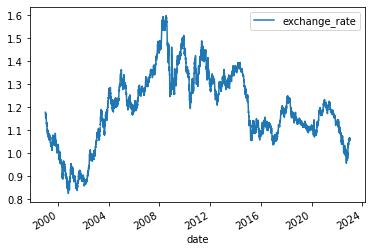

In [4]:
df.plot()

And look at the summary statistics:

In [5]:
df.describe()

,exchange_rate
count,6150.000000
mean,1.192772
std,0.158627
min,0.825200
25%,1.093300
50%,1.187650
75%,1.311475
max,1.599000


The data does not seem to have obvious outliers or mistakes. 

## 3.	Handle missing observations

We can see that there are some missing data:

In [6]:
df.isna().sum()

exchange_rate      62
contents         4380
dtype: int64

Here we fill in the exchange rate with the latest information available:

In [7]:
df.exchange_rate.fillna(method='bfill', inplace=True)

We can see there is no more missing data for exchange rate:

In [8]:
df.isna().sum()

exchange_rate       0
contents         4380
dtype: int64


## 4. Exchange rate return

Get the return by using the formula: $R_{t} = \frac{P_{t}-P_{t-1}}{P_{t-1}}$

In [9]:
df['return'] = df.exchange_rate.diff(-1)/df.exchange_rate

Extend the dataset with the variables "good_news" and "bad_news":

In [10]:
df['good_news'] = (df['return'] > 0.5/100).astype(int)
df['bad_news'] = (df['return'] < -0.5/100).astype(int)

In [11]:
df.head()

,exchange_rate,contents,return,good_news,bad_news
date,,,,,
2023-01-04,1.0599,NaN,0.005095,1,0
2023-01-03,1.0545,NaN,-0.013087,0,1
2023-01-02,1.0683,NaN,0.001591,0,0
2022-12-30,1.0666,NaN,0.001594,0,0
2022-12-29,1.0649,NaN,0.000845,0,0


## 5. Associate words with `good_news`, `bad_news`

Get the contents that associate with `good_news` and `bad_news`:

In [12]:
# remove rows with NA 
df.dropna(inplace=True)
df.head()

,exchange_rate,contents,return,good_news,bad_news
date,,,,,
2022-12-08,1.0519,SPEECH Macroprudential policy in Europe: bu...,-0.000951,0,0
2022-12-07,1.0529,SPEECH Crypto dominos: the bursting crypto ...,0.001235,0,0
2022-12-01,1.0454,SPEECH The European Climate Law and the Eu...,0.007461,1,0
2022-11-28,1.0463,SPEECH Hearing of the Committee on Economic...,0.008411,1,0
2022-11-24,1.0413,SPEECH Finding the right mix: monetary-fis...,0.008451,1,0


In [13]:
# get the contents related to "good_news" and "bad_news"
good_news_contents = df.contents[df.good_news==1].str.cat(sep=' ')
bad_news_contents = df.contents[df.bad_news==1].str.cat(sep=' ')

Load in some stop words, which are words that used to form a sentence but does not add much meaning to a sentence. Example of stop words are "a", "the" "does", "i", etc. 

In [14]:
stop_words = set(pd.read_csv("stop_words.txt", header=None).iloc[:,0].tolist())

The function below helps us to get the most common words (excluding stop_words) related to `good_news` and `bad_news`. Please read the comments to understand how it works:

In [15]:
import string
import collections

def get_word_freq(contents, stop_words, num_words):
    freq = dict()
    for word in contents.split():
        word = word.strip(string.punctuation+'–')
        word = word.lower()
        if word not in stop_words and len(word):
            if word in freq:
                freq[word] += 1
            else:
                freq[word] = 1
    freq = dict(sorted(freq.items(), key = lambda item: -item[1]))
    return list(freq.keys())[:num_words]

Use the function above to get the 20 most common words associated with `good_news` and `bad_news`

In [16]:
good_indicators = get_word_freq(good_news_contents, stop_words, num_words = 20)
bad_indicators = get_word_freq(bad_news_contents, stop_words, num_words = 20)

In [17]:
good_indicators

['euro',
 'financial',
 'policy',
 'monetary',
 'de',
 'economic',
 'market',
 'central',
 'inflation',
 'stability',
 'ecb',
 'banks',
 'european',
 'der',
 'price',
 'die',
 'growth',
 'countries',
 'la',
 'markets']

In [18]:
bad_indicators

['euro',
 'financial',
 'policy',
 'monetary',
 'market',
 'central',
 'de',
 'economic',
 'banks',
 'stability',
 'european',
 'inflation',
 'ecb',
 'growth',
 'price',
 'bank',
 'markets',
 'la',
 'countries',
 'rates']

Note that many terms appear in both, and the results are not the same as R. It may because the `word_tokenizer()` in R may not work the same way as `split()` with `strip()`.